In [ ]:
import kagglehub
samirmoustafa_arabic_to_english_translation_sentences_path = kagglehub.dataset_download('samirmoustafa/arabic-to-english-translation-sentences')
waseemalastal_arabic_english_dataset_path = kagglehub.dataset_download('waseemalastal/arabic-english-dataset')

print('Data source import complete.')


100%|██████████| 2.16M/2.16M [00:00<00:00, 62.1MB/s]

Extracting files...


100%|██████████| 498k/498k [00:00<00:00, 60.7MB/s]

Extracting files...
Data source import complete.


In [ ]:
!pip install transformers -q

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tf_keras as keras
import torch
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from transformers import AutoTokenizer, AutoModel, TFAutoModelForSeq2SeqLM, TFAutoModelForSequenceClassification

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tf_keras.models import Model
from tf_keras.layers import Input, Embedding as TFEmbedding, LSTM as TFLSTM, Bidirectional as TFBidirectional, Dense as TFDense, Dropout as TFDropout, Layer

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
path = f"{samirmoustafa_arabic_to_english_translation_sentences_path}/ara_eng.txt"

df = pd.read_csv(
    path,
    sep="\t", # separate the tab between coloumns
    names=["english", "arabic"] #we add coloumn names
)

print(df.head())
print(df.shape)


  english   arabic
0     Hi.  مرحبًا.
1    Run!    اركض!
2   Help!  النجدة!
3   Jump!    اقفز!
4   Stop!      قف!
(24638, 2)


24638 → the dataset has 24,638 sentences (rows)

2 → there are 2 columns (English & Arabic)

In [ ]:
#converting the translation dataset into a classification dataset:
#English sentences → label 0
#Arabic sentences → label 1
eng_df = pd.DataFrame({
    "text": df["english"].astype(str),
    "label": 0
})

ar_df = pd.DataFrame({
    "text": df["arabic"].astype(str),
    "label": 1
})

data = pd.concat([eng_df, ar_df], ignore_index=True)


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text) #replace newline characters (\n) with a space.
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) #removes all characters that are NOT letters, numbers, or spaces
    text = re.sub(r'\s+', ' ', text)#Replaces multiple spaces with a single space.
    return text.strip()# remove the spaces in the begging and end of any text

def conditional_clean(row):
    if row["label"] == 0:
        return clean_text(row["text"])
    else:
        return row["text"]
data["text_clean"] = data.apply(conditional_clean, axis=1)



In [ ]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("[ًٌٍَُِّْ]", "", text)
    return text

def preprocess(row):
    # Apply normalize_arabic only if label is 1, else return text as-is
    return normalize_arabic(row["text"]) if row["label"] == 1 else row["text"]

data["lemmas"] = data.apply(preprocess, axis=1)

In [ ]:
nltk.download('punkt_tab') #Download punkttab (to split text into words) from NLTK
data["tokens"] = data["text"].astype(str).apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
arabic_stop = set(stopwords.words("arabic")) #gives a list of common Arabic stopwords.
english_stop = set(stopwords.words("english"))

In [ ]:
# Define a function that removes Arabic stopwords using a for loop
def remove_arabic_stopwords(token_list):
    result = []
    for w in token_list:
        if w not in arabic_stop:
            result.append(w)
    return result

# Apply the function to the "tokens" column
data["tokens_no_stop"] = data["tokens"].apply(remove_arabic_stopwords)


In [ ]:
def remove_english_stopwords(token_list):
    result = []
    for w in token_list:
        if w.lower() not in english_stop:
            result.append(w)
    return result

# Apply the function to the "tokens" column
data["tokens_no_stop"] = data["tokens"].apply(remove_english_stopwords)

In [ ]:
def lemmatize_tokens(token_list):
    result = []
    for w in token_list:
        result.append(lemmatizer.lemmatize(w.lower()))
    return result

data["lemmas"] = data.apply(
    lambda row: lemmatize_tokens(row["tokens_no_stop"]) if row["label"] == 0 else row["tokens_no_stop"],
    axis=1
)


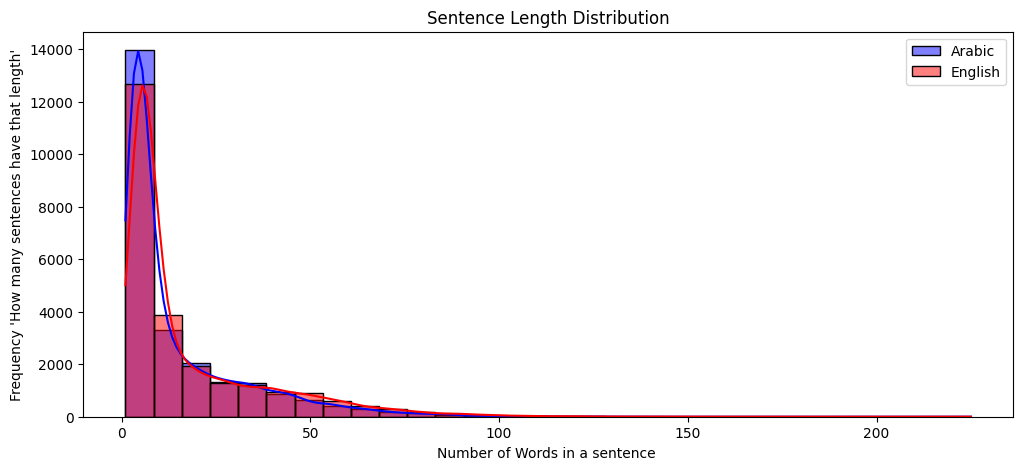

In [ ]:
df["arabic_length"] = df["arabic"].apply(lambda x: len(str(x).split()))
#str(x) → makes sure the text is a string
#.split() → splits the sentence into words
#len(...) → counts how many words
#The result is saved in a new column: arabic_length
df["english_length"] = df["english"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12,5))
sns.histplot(df["arabic_length"], kde=True, color="blue", bins=30, label="Arabic")
sns.histplot(df["english_length"], kde=True, color="red", bins=30, label="English")
plt.legend()
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words in a sentence ")
plt.ylabel("Frequency 'How many sentences have that length'")
plt.show()


In [ ]:
print("Arabic Length Stats:")
print(df["arabic_length"].describe())

print("\nEnglish Length Stats:")
print(df["english_length"].describe())


Arabic Length Stats:
count    24638.000000
mean        15.054956
std         17.630803
min          1.000000
25%          4.000000
50%          7.000000
75%         20.000000
max        225.000000
Name: arabic_length, dtype: float64

English Length Stats:
count    24638.000000
mean        17.630692
std         19.864838
min          1.000000
25%          5.000000
50%          8.000000
75%         23.000000
max        225.000000
Name: english_length, dtype: float64


In [ ]:
def get_word_counts_no_stop(text_series, stopwords_set):
    # Join all sentences, split into words
    all_words = " ".join(text_series).split()
    # Remove stopwords
    filtered_words = [w for w in all_words if w not in stopwords_set]
    # Count remaining words
    return Counter(filtered_words)

# Count Arabic words without stopwords
arabic_freq = get_word_counts_no_stop(df["arabic"], arabic_stop)
# Count English words without stopwords
english_freq = get_word_counts_no_stop(df["english"], english_stop)

# Display results
print("\nMost Common Arabic Words (no stopwords):")
print(arabic_freq.most_common(10))

print("\nMost Common English Words (no stopwords):")
print(english_freq.most_common(10))


Most Common Arabic Words (no stopwords):
[('ان', 3213), ('العالمية', 2809), ('الاصوات', 2732), ('الى', 2292), ('الانترنت', 1014), ('او', 1005), ('توم', 810), ('موقع', 707), ('تم', 702), ('حول', 702)]

Most Common English Words (no stopwords):
[('global', 2708), ('I', 2377), ('voices.', 2001), ('people', 981), ('one', 940), ('Tom', 848), ('also', 760), ('like', 750), ('new', 694), ('voices', 690)]


In [ ]:
eng_df

,text,label
0,Hi.,0
1,Run!,0
2,Help!,0
3,Jump!,0
4,Stop!,0
...,...,...
24633,rising voices promoting a more linguistically ...,0
24634,following last year s successful campaign we i...,0
24635,during last year s challenge we also met langu...,0
24636,to take part just follow the simple steps outl...,0


In [ ]:
ar_df

,text,label
0,مرحبًا.,1
1,اركض!,1
2,النجدة!,1
3,اقفز!,1
4,قف!,1
...,...,...
24633,شاركنا تحدي ابداع ميم بلغتك الام تعزيزا للتنوع...,1
24634,استكمالا لنجاح حملة العام السابق ندعوكم للمشار...,1
24635,تعرفنا خلال تحدي العام الماضي على ابطال لغويين...,1
24636,للمشاركة في التحدي اتبع الخطوات الموضحة على ال...,1


In [ ]:
df["english"] = df["english"].astype(str)
df["arabic"]  = df["arabic"].astype(str)

df["english_clean"] = df["english"].apply(clean_text)

df["arabic_norm"] = df["arabic"].apply(normalize_arabic)

X_train, X_test, y_train, y_test = train_test_split(
    df["english_clean"], df["arabic_norm"],
    test_size=0.2, random_state=42
)


TF-IDF Gives a weighted representation of words in documents.

TF (Term Frequency): how often a word appears in a document.

IDF (Inverse Document Frequency): downweights words that appear in many documents, because they are less informative (like "the", "and").

In [ ]:
tfidf = TfidfVectorizer(analyzer="char", ngram_range=(1, 3), min_df=5)
#Converts X_train and X_test to strings.
X_train_text = X_train.astype(str)
X_test_text  = X_test.astype(str)
#Learns the TF-IDF vocabulary and IDF weights from the training data.
#Converts training text into a sparse TF-IDF matrix.
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf  = tfidf.transform(X_test_text)


In [ ]:
!pip install gensim -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 19.4 MB/s eta 0:00:00


In [ ]:
# Install gensim if not already
# !pip install gensim scikit-learn matplotlib

import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

# Take a random sample of 1500 sentences
sample = data.sample(1500, random_state=42)

# Prepare tokenized sentences
sentences = sample["tokens_no_stop"].tolist()  # list of lists of tokens


In [ ]:
# Train Word2Vec model
w2v_model = Word2Vec(
    sentences,
    vector_size=100,   # embedding dimension
    window=5,          # context window
    min_count=1,       # ignore words with frequency < 1
    workers=4          # CPU cores
)



In [ ]:
# Compute sentence embeddings by averaging word vectors
def get_sentence_embedding(tokens, model):
    vecs = [model.wv[word] for word in tokens if word in model.wv]
    if len(vecs) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

sentence_embeddings = np.array([get_sentence_embedding(s, w2v_model) for s in sentences])
print("Sentence embeddings shape:", sentence_embeddings.shape)

Sentence embeddings shape: (1500, 100)


PCA embeddings shape: (1500, 2)


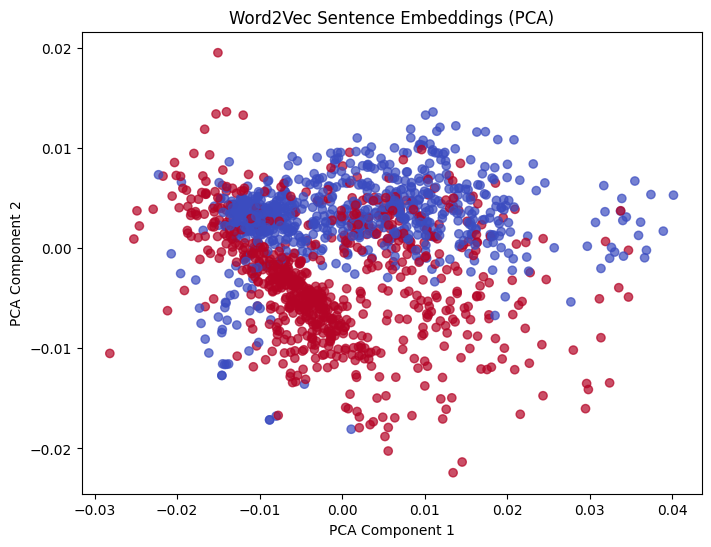

In [ ]:
# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(sentence_embeddings)
print("PCA embeddings shape:", embeddings_2d.shape)  # should be (1500, 2)

# Scatter plot with color = label (English=0, Arabic=1)
plt.figure(figsize=(8,6))
plt.scatter(
    embeddings_2d[:,0],
    embeddings_2d[:,1],
    c=sample["label"].values,   # convert to numpy array
    cmap="coolwarm",
    alpha=0.7
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Word2Vec Sentence Embeddings (PCA)")
plt.show()


Phase 2

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

MAX_WORDS_EN = 12000
MAX_WORDS_AR = 12000
MAX_LEN = 35

ar_texts = ("<sos> " + df["arabic_norm"].astype(str) + " <eos>").tolist()
en_texts = df["english_clean"].astype(str).tolist()

en_tok = Tokenizer(num_words=MAX_WORDS_EN, oov_token="<unk>")
ar_tok = Tokenizer(num_words=MAX_WORDS_AR, oov_token="<unk>", filters="")  # important: keep < > tokens

en_tok.fit_on_texts(en_texts)
ar_tok.fit_on_texts(ar_texts)

en_seq = en_tok.texts_to_sequences(en_texts)
ar_seq = ar_tok.texts_to_sequences(ar_texts)

en_pad = pad_sequences(en_seq, maxlen=MAX_LEN, padding="post", truncating="post")
ar_pad = pad_sequences(ar_seq, maxlen=MAX_LEN, padding="post", truncating="post")

en_train, en_test, ar_train, ar_test = train_test_split(
    en_pad, ar_pad, test_size=0.2, random_state=42
)

ar_in_train  = ar_train[:, :-1]
ar_out_train = ar_train[:, 1:]
ar_in_test   = ar_test[:, :-1]
ar_out_test  = ar_test[:, 1:]

ar_out_train = np.expand_dims(ar_out_train, -1)
ar_out_test  = np.expand_dims(ar_out_test, -1)

EN_VOCAB = min(MAX_WORDS_EN, len(en_tok.word_index) + 1)
AR_VOCAB = min(MAX_WORDS_AR, len(ar_tok.word_index) + 1)

print("EN_VOCAB:", EN_VOCAB, "AR_VOCAB:", AR_VOCAB)


EN_VOCAB: 12000 AR_VOCAB: 12000


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

EMB_DIM = 256
UNITS = 256
DROPOUT = 0.25

# Encoder
enc_in = layers.Input(shape=(MAX_LEN,), name="enc_in")
enc_emb = layers.Embedding(
    EN_VOCAB, EMB_DIM, mask_zero=False, name="enc_emb"
)(enc_in)

enc_out = layers.Bidirectional(
    layers.LSTM(UNITS, return_sequences=True, dropout=DROPOUT),
    name="enc_bilstm"
)(enc_emb)

# Decoder
dec_in = layers.Input(shape=(MAX_LEN - 1,), name="dec_in")
dec_emb = layers.Embedding(
    AR_VOCAB, EMB_DIM, mask_zero=False, name="dec_emb"
)(dec_in)

dec_out = layers.LSTM(
    UNITS * 2, return_sequences=True, dropout=DROPOUT, name="dec_lstm"
)(dec_emb)

# Attention (stable configuration)
attn = layers.AdditiveAttention(name="attn")([dec_out, enc_out])

# Output
concat = layers.Concatenate(name="concat")([dec_out, attn])
proj = layers.Dense(UNITS * 2, activation="tanh", name="proj")(concat)
proj = layers.Dropout(DROPOUT)(proj)

out = layers.Dense(AR_VOCAB, name="out_vocab")(proj)

model = Model([enc_in, dec_in], out)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=loss_fn,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="tok_acc")]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dec_in (InputLayer) │ (None, 34)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_in (InputLayer) │ (None, 35)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_emb (Embedding) │ (None, 34, 256)   │  3,072,000 │ dec_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_emb (Embedding) │ (None, 35, 256)   │  3,072,000 │ enc_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_lstm (LSTM)     │ (None, 34, 512)   │  1,574,912 │ dec_emb[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_bilstm          │ (None, 35, 512)   │  1,050,624 │ enc_emb[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn                │ (None, 34, 512)   │        512 │ dec_lstm[0][0],   │
│ (AdditiveAttention) │                   │            │ enc_bilstm[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 34, 1024)  │          0 │ dec_lstm[0][0],   │
│ (Concatenate)       │                   │            │ attn[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ proj (Dense)        │ (None, 34, 512)   │    524,800 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 34, 512)   │          0 │ proj[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out_vocab (Dense)   │ (None, 34, 12000) │  6,156,000 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,450,848 (58.94 MB)

 Trainable params: 15,450,848 (58.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
BATCH = 32
EPOCHS = 15

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(
    [en_train, ar_in_train],
    ar_out_train,
    validation_data=([en_test, ar_in_test], ar_out_test),
    batch_size=BATCH,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/15
616/616 ━━━━━━━━━━━━━━━━━━━━ 119s 143ms/step - loss: 3.1932 - tok_acc: 0.6469 - val_loss: 2.4381 - val_tok_acc: 0.6934 - learning_rate: 0.0010
Epoch 2/15
616/616 ━━━━━━━━━━━━━━━━━━━━ 87s 142ms/step - loss: 2.3938 - tok_acc: 0.6941 - val_loss: 2.3027 - val_tok_acc: 0.7021 - learning_rate: 0.0010
Epoch 3/15
616/616 ━━━━━━━━━━━━━━━━━━━━ 91s 147ms/step - loss: 2.2650 - tok_acc: 0.6961 - val_loss: 2.2030 - val_tok_acc: 0.7073 - learning_rate: 0.0010
Epoch 4/15
616/616 ━━━━━━━━━━━━━━━━━━━━ 132s 132ms/step - loss: 2.0445 - tok_acc: 0.7109 - val_loss: 2.1219 - val_tok_acc: 0.7128 - learning_rate: 0.0010
Epoch 5/15
616/616 ━━━━━━━━━━━━━━━━━━━━ 67s 108ms/step - loss: 1.8723 - tok_acc: 0.7198 - val_loss: 2.0721 - val_tok_acc: 0.7157 - learning_rate: 0.0010
Epoch 6/15
616/616 ━━━━━━━━━━━━━━━━━━━━ 84s 112ms/step - loss: 1.7290 - tok_acc: 0.7253 - val_loss: 2.0430 - val_tok_acc: 0.7194 - learning_rate: 0.0010
Epoch 7/15
616/616 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - loss: 1.5517 - tok_acc: 

In [ ]:
def get_token_id(tok, candidates, default=None):
    for t in candidates:
        if t in tok.word_index:
            return tok.word_index[t]
        if t.lower() in tok.word_index:
            return tok.word_index[t.lower()]
        if t.upper() in tok.word_index:
            return tok.word_index[t.upper()]
    return default

def greedy_decode(model, en_seq_1, ar_tok, max_len):
    pad_id = 0
    sos_id = get_token_id(ar_tok, ["<sos>", "sos"])
    eos_id = get_token_id(ar_tok, ["<eos>", "eos"], default=-1)

    if sos_id is None:
        raise ValueError("SOS token not found in ar_tok.word_index (need <sos> or sos).")

    dec = np.full((1, max_len - 1), pad_id, dtype=np.int32)
    dec[0, 0] = sos_id

    out_ids = []
    for t in range(1, max_len - 1):
        logits = model.predict([en_seq_1, dec], verbose=0)
        next_id = int(np.argmax(logits[0, t-1]))

        out_ids.append(next_id)
        dec[0, t] = next_id
        if eos_id != -1 and next_id == eos_id:
            break

    return out_ids

def ids_to_text(ar_tok, ids):
    inv = {v: k for k, v in ar_tok.word_index.items()}
    words = []
    for i in ids:
        w = inv.get(int(i), "")
        if w in ["<sos>", "sos", ""] or w is None:
            continue
        if w in ["<eos>", "eos"]:
            break
        words.append(w)
    return " ".join(words).strip()

In [ ]:
def translate_one(sentence_en):
    s = clean_text(str(sentence_en))
    seq = en_tok.texts_to_sequences([s])
    seq = pad_sequences(seq, maxlen=MAX_LEN, padding="post", truncating="post")
    pred_ids = greedy_decode(model, seq, ar_tok, MAX_LEN)
    return ids_to_text(ar_tok, pred_ids)

print("Example:")
print("EN:", "i love you")
print("AR:", translate_one("i love you"))

Example:
EN: i love you
AR: احبك.


In [ ]:
print("Example:")
print("EN:", "How are you?")
print("AR:", translate_one("How are you?"))

Example:
EN: How are you?
AR: كيف حالك؟


In [ ]:
print("Example:")
print("EN:", "Thank you")
print("AR:", translate_one("Thank you"))

Example:
EN: Thank you
AR: شكرا <unk>


In [ ]:
print("Example:")
print("EN:", "i like banana")
print("AR:", translate_one("i like banana"))

Example:
EN: i like banana
AR: احب <unk>


In [ ]:
# ==============================
# SECOND MODEL: Helsinki-NLP BERT-based (Transformer)
# ==============================

!pip install transformers sentencepiece sacrebleu -q

from transformers import pipeline
import sacrebleu
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the pre-trained English-to-Arabic translation model (based on MarianMT, which uses Transformer architecture similar to BERT-style encoders)
translator = pipeline("translation_en_to_ar",
                      model="Helsinki-NLP/opus-mt-en-ar",
                      device=0 if torch.cuda.is_available() else -1)  # Use GPU if available

print("BERT-based Transformer model loaded: Helsinki-NLP/opus-mt-en-ar")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/801k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/917k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


BERT-based Transformer model loaded: Helsinki-NLP/opus-mt-en-ar


another way

In [ ]:
from tqdm import tqdm
import numpy as np

n_eval = 600  # or 800 if you have time

refs = []
lstm_preds = []
bert_preds = []

print("Generating translations for evaluation...")

for i in tqdm(range(n_eval)):
    # Reconstruct clean English text (with spaces + lowercase)
    en_ids = en_test[i]
    en_words = [en_tok.index_word.get(idx, '').lower() for idx in en_ids if idx != 0]
    en_text = ' '.join(en_words).strip()

    # Ground truth Arabic
    true_ids = ar_out_test[i] if ar_out_test.ndim == 2 else ar_out_test[i][:,0]
    ref_text = ids_to_text(ar_tok, true_ids)
    refs.append(ref_text)

    # LSTM prediction (unchanged)
    lstm_pred_ids = greedy_decode(model, en_test[i:i+1], ar_tok, MAX_LEN_USED)
    lstm_text = ids_to_text(ar_tok, lstm_pred_ids)
    lstm_preds.append(lstm_text)

    # Helsinki prediction (now with clean lowercase input)
    try:
        bert_result = translator(en_text, max_length=128)[0]['translation_text']
    except:
        bert_result = ""
    bert_preds.append(bert_result)

print("Done!")

Generating translations for evaluation...


100%|██████████| 600/600 [14:18<00:00,  1.43s/it]

Translation generation complete.


In [ ]:
translator = pipeline(
    "translation_en_to_ar",
    model="Helsinki-NLP/opus-mt-en-ar",
    device=0 if torch.cuda.is_available() else -1,
    max_length=128  # Higher limit → fewer warnings, better long sentences
)

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


In [ ]:
import random

print("\n" + "="*80)
print("RANDOM 10 TRANSLATION EXAMPLES (English → Arabic)")
print("="*80)

# Randomly select 10 indices from the evaluated samples
indices = random.sample(range(len(refs)), 10)

for count, idx in enumerate(indices, 1):
    # Reconstruct the original English sentence (clean, with spaces, lowercase)
    en_ids = en_test[idx]
    en_words = [en_tok.index_word.get(id, '').lower() for id in en_ids if id != 0]
    en_text = ' '.join(en_words).strip()

    print(f"\nExample {count}:")
    print(f"English Input   : {en_text}")
    print(f"Reference Arabic: {refs[idx]}")
    print(f"Custom LSTM     : {lstm_preds[idx]}")
    print(f"Helsinki Model  : {bert_preds[idx]}")
    print("-" * 60)

print("\nFinished printing examples!")


RANDOM 10 TRANSLATION EXAMPLES (English → Arabic)

Example 1:
English Input   : do i look like im kidding
Reference Arabic: هل يبدو لك باني <unk>
Custom LSTM     : انا <unk> <unk>
Helsinki Model  : هل أبدو وكأني ام ام ام
------------------------------------------------------------

Example 2:
English Input   : these paintings have been well known for a long time and they can be easily seen as they are located near the road of <unk> we have photographs taken almost years ago and there are
Reference Arabic: عرفت هذه الرسومات منذ زمن طويل ويمكن <unk> بسهوله <unk> من طريق <unk> لدينا صور ملتقطه منذ ما يقرب من عاما كما يوجد كثير من <unk> <unk> علي علم <unk> ذكرنا تلك الرسومات في
Custom LSTM     : هذه <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Helsinki Model  : هذه اللوحات كانت معروفة جيداً منذ فترة طويلة ويمكن رؤيتها بسهولة لأنها تقع بالقرب من